In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import dotenv
import requests
from requests.auth import HTTPBasicAuth
import os
from scipy import stats

plt.rcParams["font.family"] = "Arial"
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 12
plt.rcParams["ytick.major.size"] = 12
plt.rcParams["xtick.major.pad"] = 18
plt.rcParams["ytick.major.pad"] = 18
plt.rcParams['axes.linewidth'] = 1.0

dotenv.load_dotenv()

True

In [2]:
star = pd.read_csv("./data/user_info_1.csv")
star.head()

,username,star,created_at,updated_at,elapsed_time,star_per_day,star_per_day_biased,issue_count,issue_per_day_biased
0,collymore,8,2009-02-19 16:16:06,2020-09-26 11:37:56,4236,0.001889,0.001889,7,0.001653
1,sujanucsc,9,2009-03-12 16:20:20,2020-08-16 18:30:00,4175,0.002156,0.002156,0,0.000000
2,Theorem,0,2018-03-15 21:04:11,2020-07-28 05:07:27,865,0.000000,0.000000,0,0.000000
3,mussawir20,1,2009-05-03 00:01:17,2020-09-18 14:41:17,4156,0.000241,0.000241,0,0.000000
4,bytheway,958,2008-04-04 17:43:29,2020-09-24 13:30:55,4555,0.210318,0.210318,11,0.002415


## 追加の処理

最初の１回のみ実行する

In [ ]:
created_at = []
updated_at = []

for i in range(len(star)):
    created_at.append(datetime.strptime(star["created_at"][i], "%Y-%m-%dT%H:%M:%SZ"))
    updated_at.append(datetime.strptime(star["updated_at"][i], "%Y-%m-%dT%H:%M:%SZ"))

In [18]:
star["created_at"] = created_at
star["updated_at"] = updated_at

In [32]:
auth = HTTPBasicAuth(
    os.environ.get("GITHUB_USERNAME"), os.environ.get("GITHUB_TOKEN")
)

for i in range(len(star)):
    if star.star[i] == 100:
        page = 1
        cnt = 0
        while True:
            data = requests.get(
                f"https://api.github.com/users/{star.username[i]}/starred?per_page=100&page={page}",
                auth=auth
            ).json()
            
            if len(data) == 0:
                break
            
            cnt += len(data)
            page += 1
        
        star.star[i] = cnt

<ipython-input-32-036830168289>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  star.star[i] = cnt


In [34]:
star.to_csv("./data/user_info_1.csv", index=False)

## データの解析

In [4]:
star.head()

,username,star,created_at,updated_at,elapsed_time,star_per_day,star_per_day_biased,issue_count,issue_per_day_biased
0,collymore,8,2009-02-19 16:16:06,2020-09-26 11:37:56,4236,0.001889,0.001889,7,0.001653
1,sujanucsc,9,2009-03-12 16:20:20,2020-08-16 18:30:00,4175,0.002156,0.002156,0,0.000000
2,Theorem,0,2018-03-15 21:04:11,2020-07-28 05:07:27,865,0.000000,0.000000,0,0.000000
3,mussawir20,1,2009-05-03 00:01:17,2020-09-18 14:41:17,4156,0.000241,0.000241,0,0.000000
4,bytheway,958,2008-04-04 17:43:29,2020-09-24 13:30:55,4555,0.210318,0.210318,11,0.002415


In [ ]:
to_day = lambda x: x.days + 1
# star["elapsed_time"] = (star.updated_at - star.created_at).apply(to_day)

In [268]:
star["star_per_day"] = star["star"] / star["elapsed_time"]

In [42]:
def func(x):
    bias = 0 if x.elapsed_time > 1000 else 1000 - x.elapsed_time
    
    return x.star / (bias + x.elapsed_time)

star["star_per_day_biased"] = star.apply(func, axis=1)

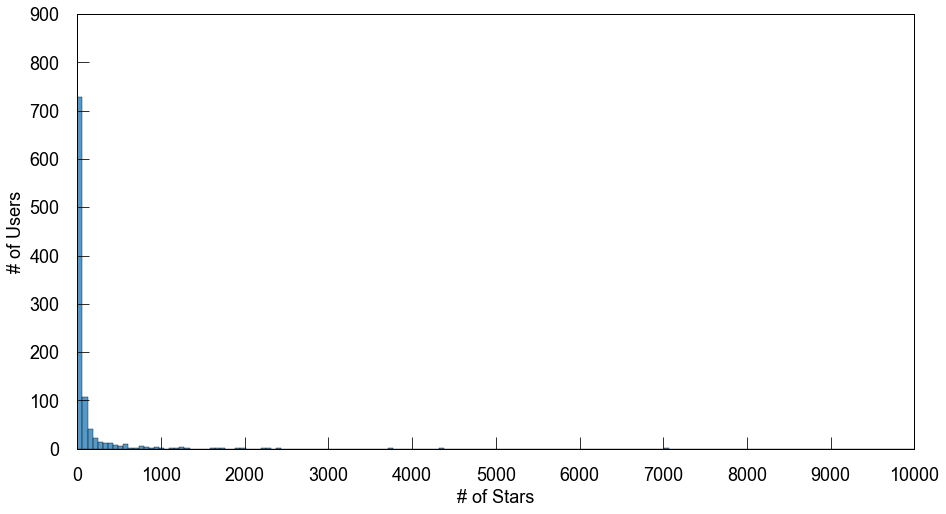

In [43]:
plt.figure(figsize=(15,8))
sns.histplot(star.star, bins=200)
plt.xticks([1000*i for i in range(11)])
plt.xlim(0, 10000)
plt.ylim(0, 900)
plt.xlabel("# of Stars", fontsize=18)
plt.ylabel("# of Users", fontsize=18)
plt.savefig("./star_per_day.svg", transparent=True)
plt.show()

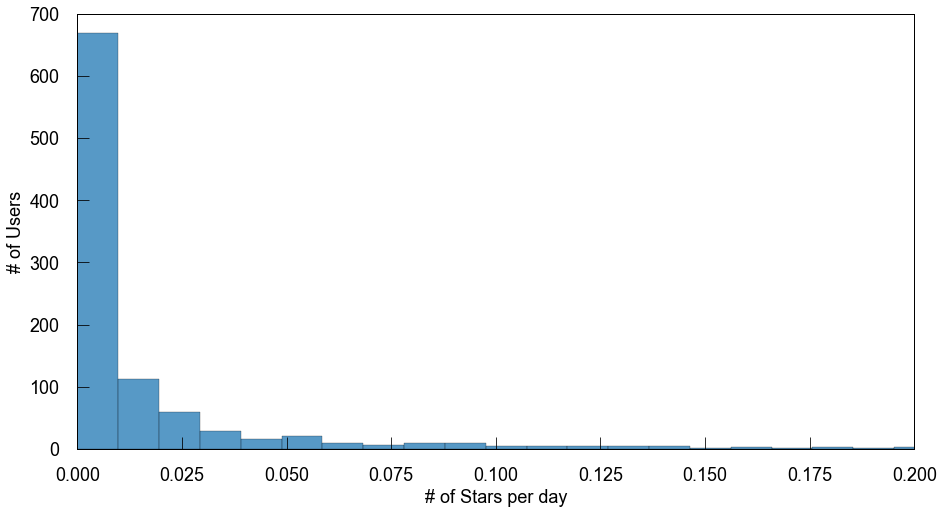

In [44]:
plt.figure(figsize=(15,8))
sns.histplot(star.star_per_day_biased, bins=300)
plt.xlabel("# of Stars per day", fontsize=18)
plt.ylabel("# of Users", fontsize=18)
plt.xlim(0, 0.2)
plt.ylim(0, 700)
plt.savefig("./star_per_day.svg", transparent=True)
plt.show()

In [45]:
max(star.star_per_day_biased)

2.927438731379145

ロジット変換

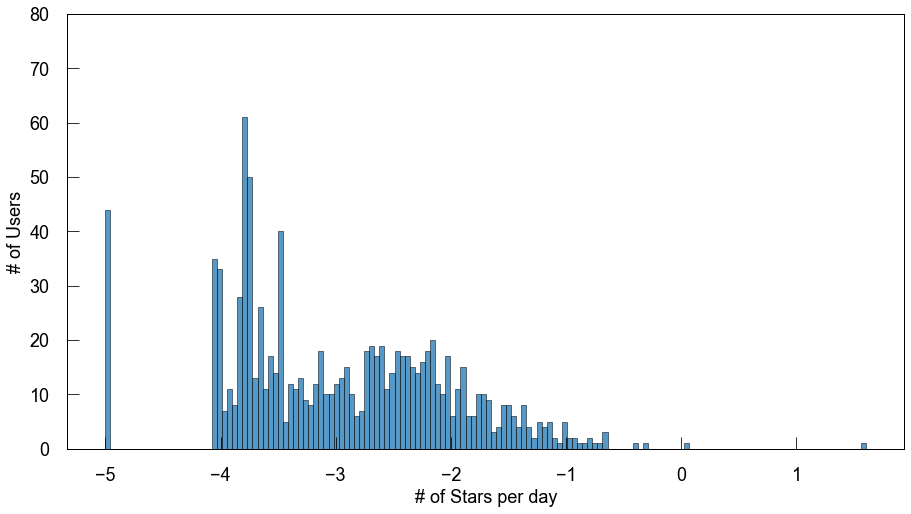

In [46]:
# s = star[(star.star_per_day_biased > 0) & (star.star_per_day_biased < 1)].star_per_day_biased
s = star.star_per_day_biased / 3 + 1e-5

plt.figure(figsize=(15,8))
sns.histplot(np.log10(s/(1-s)), bins=150)
plt.xlabel("# of Stars per day", fontsize=18)
plt.ylabel("# of Users", fontsize=18)
#plt.xlim(0, 0.2)
plt.ylim(0, 80)
#plt.savefig("./star_per_day.svg", transparent=True)
plt.show()

-5 にあるバーはスター数が０のユーザー。それを除いてもピークが２つある気がする。それぞれの山に特徴はある？スター数が０のユーザーは除いて `elapsed_time` によって分布を分割してみる

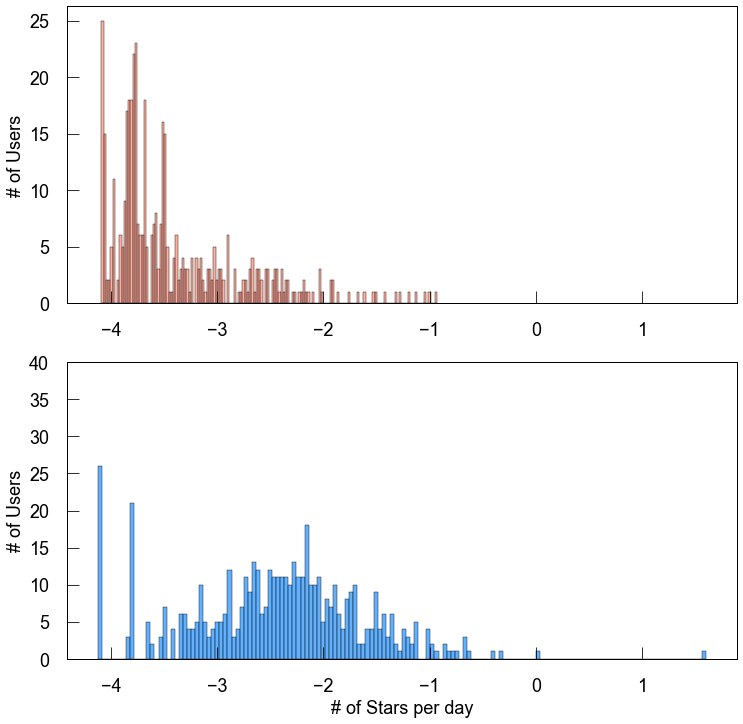

In [75]:
# s = star[(star.star_per_day_biased > 0) & (star.star_per_day_biased < 1)].star_per_day_biased
th = 4100
s_new = star[(star.elapsed_time < th) & (star.star_per_day_biased > 0)].star_per_day_biased / 3
s_old = star[(star.elapsed_time >= th) & (star.star_per_day_biased > 0)].star_per_day_biased / 3

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)
sns.histplot(np.log10(s_new/(1-s_new)), bins=150, color="tomato", alpha=0.5, ax=ax1)
sns.histplot(np.log10(s_old/(1-s_old)), bins=150, color="dodgerblue", alpha=0.7, ax=ax2)
ax2.set_xlabel("# of Stars per day", fontsize=18)
ax2.set_ylabel("# of Users", fontsize=18)
ax1.set_xlabel("")
ax1.set_ylabel("# of Users", fontsize=18)
#plt.xlim(0, 0.2)
plt.ylim(0, 40)
#plt.savefig("./star_per_day.svg", transparent=True)
plt.show()

In [63]:
print("Long users:")
print(f"Stdev biased: {stats.tstd(np.log10(s_old/(1-s_old))):.4}")
print(f"Mean: {np.log10(s_old/(1-s_old)).mean():.4}")
print(f"Median: {np.log10(s_old/(1-s_old)).median():.4}")
print("New users:")
print(f"Stdev biased: {stats.tstd(np.log10(s_new/(1-s_new))):.4}")
print(f"Mean: {np.log10(s_new/(1-s_new)).mean():.4}")
print(f"Median: {np.log10(s_new/(1-s_new)).median():.4}")

Long users:
Stdev biased: 0.8237
Mean: -2.447
Median: -2.385
New users:
Stdev biased: 0.6361
Mean: -3.405
Median: -3.641


In [66]:
def hensati(x):
    return (x + 2.447) / 2.385 * 10 + 50

In [71]:
hensati(np.log10(1/9000/(1-1/3000)))

43.68093198960508

In [233]:
star.to_csv("./data/user_info_1.csv", index=False)

GitHub アカウントを作って時間が経ってない人は少しスターをつける数が増えるだけで１日あたりのスター数が急激に増えて`log10(10*x + 1)` が一気に増えてしまう。

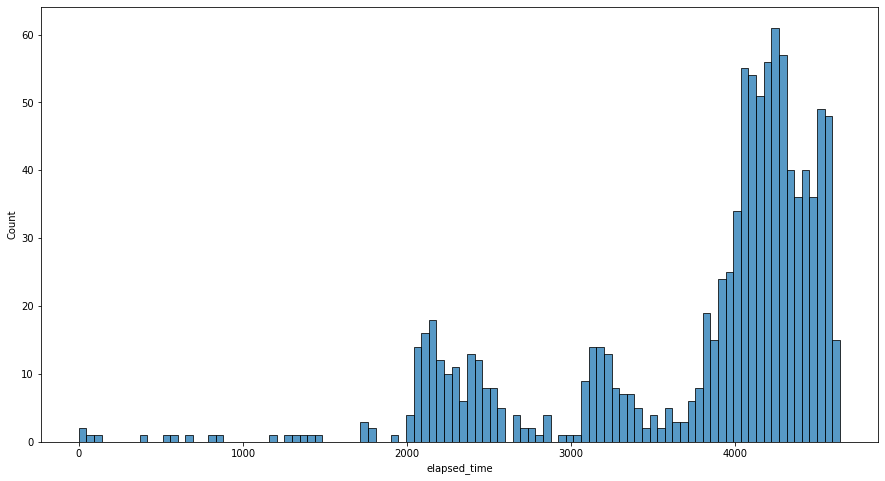

In [167]:
plt.figure(figsize=(15,8))
sns.histplot(star.elapsed_time, bins=100)
plt.show()